In [2]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
def load_stopwords(file_path):
    stopwords = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            stopwords.append(line.strip())  # 각 줄의 공백 및 줄 바꿈 문자 제거 후 리스트에 추가
    return stopwords


In [5]:
file_path = 'stopwords-ko.txt'

In [6]:
korean_stopwords = load_stopwords(file_path)

In [7]:
print(korean_stopwords)

['가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공동으로', '과', '과연', '관계가 있다', '관계없이', '관련이 있다', '관하여', '관한', '관해서는', '구', '구체적으로', '구토하다', '그', '그들', '그때', '그래', '그래도', '그래서', '그러나', '그러니', '그러니까', '그러면', '그러므로', '그러한즉', '그런 까닭에', '그런데', '그런즉', '그럼', '그럼에도 불구하고', '그렇게 함으로써', '그렇지', '그렇지 않다면', '그렇지 않으면', '그렇지만', '그렇지않으면', '그리고', '그리하여', '그만이다', '그에 따르는', '그위에', '그저', '그중에서', '그치지 않다', '근거로', '근거하여', '기대여', '기점으로', '기준으로', '기타', '까닭으로', '까악', '까지', '까지 미치다', '까지도', '꽈당', '끙끙', '끼익', '나', '나머지는', '남들', '남짓', '너', '너희', '너희들', '네', '넷', '년', '논하지 않다', '놀라다', '누가 알겠는가', '누구', '다른', '다른 방면으로', '다만', '다섯', '다소', '다수', '다시 말하자면', '다시말하면', '다음', '다음에', '다음으로', '단지', '답다', '당신', '당장', '대로 하다', '대하면', '대하여', '대해 말하자면', '대해서', '댕그', '더구나', '더군다나', '더라도', '더불어', '더욱더', '더욱이는', '도달하다', '도착하다', '동시에', '동안', '된바에야', '된이상', '두번째로', '둘', '둥둥', '뒤따라', '뒤이어'

In [8]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = korean_stopwords



def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, Dense

# 데이터 로드
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

# 데이터 전처리
def preprocess_data(data):
  data.drop_duplicates(subset=['document'], inplace=True)
  data.dropna(how='any', inplace=True)
  return data

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# 문장 길이 계산
sentence_lengths = [len(sentence) for sentence in train_data['document']]

# max_len 계산 (정수 변환 추가)
max_len = int(np.percentile(sentence_lengths, 95))

# 토큰화 및 불용어 제거
tokenizer = Mecab()
stopwords = korean_stopwords

def tokenize(text):
  return [token for token in tokenizer.morphs(text) if not token in stopwords]

X_train = [tokenize(sentence) for sentence in train_data['document']]
X_test = [tokenize(sentence) for sentence in test_data['document']]

# 레이블
y_train = train_data['label'].tolist()
y_test = test_data['label'].tolist()

# y_train, y_test를 NumPy 배열로 변환
y_train = np.array(y_train)  
y_test = np.array(y_test)   

# 단어 집합 및 인덱스 매핑
vocab = np.concatenate(X_train).tolist()
counter = Counter(vocab)
counter = counter.most_common(10000-4)
vocab = ['', '', '', ''] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

def wordlist_to_indexlist(wordlist):
  return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

# 패딩 (정수 변환 확인)
X_train = pad_sequences(X_train, maxlen=int(max_len))
X_test = pad_sequences(X_test, maxlen=int(max_len))

# 모델 구성
def create_model(vocab_size, embedding_dim, max_len):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(LSTM(128))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

# 모델 학습 및 평가
model = create_model(len(vocab), 128, max_len)
model.fit(X_train, y_train, epochs=10, batch_size=64)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"테스트 손실: {loss}")
print(f"테스트 정확도: {accuracy}")

# 모델 저장
model.save('sentiment_model.h5')


Epoch 1/10
2285/2285 [==============================] - 47s 8ms/step - loss: 0.3690 - accuracy: 0.8338
Epoch 2/10
2285/2285 [==============================] - 17s 8ms/step - loss: 0.2867 - accuracy: 0.8786
Epoch 3/10
2285/2285 [==============================] - 17s 7ms/step - loss: 0.2485 - accuracy: 0.8959
Epoch 4/10
2285/2285 [==============================] - 17s 8ms/step - loss: 0.2140 - accuracy: 0.9123
Epoch 5/10
2285/2285 [==============================] - 17s 8ms/step - loss: 0.1812 - accuracy: 0.9274
Epoch 6/10
2285/2285 [==============================] - 17s 8ms/step - loss: 0.1498 - accuracy: 0.9408
Epoch 7/10
2285/2285 [==============================] - 17s 8ms/step - loss: 0.1227 - accuracy: 0.9521
Epoch 8/10
2285/2285 [==============================] - 17s 7ms/step - loss: 0.1021 - accuracy: 0.9598
Epoch 9/10
2285/2285 [==============================] - 17s 8ms/step - loss: 0.0856 - accuracy: 0.9670
Epoch 10/10
1537/1537 [==============================] - 6s 3ms/step - lo

In [12]:
import pandas as pd
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Conv1D, MaxPooling1D, Dense, Attention
from sklearn.model_selection import train_test_split

# 데이터 로드
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')

# 데이터 전처리
def preprocess_data(data):
  data.drop_duplicates(subset=['document'], inplace=True)
  data.dropna(how='any', inplace=True)
  return data

train_data = preprocess_data(train_data)

# 문장 길이 계산
sentence_lengths = [len(sentence) for sentence in train_data['document']]

# max_len 계산 (정수 변환 추가)
max_len = int(np.percentile(sentence_lengths, 95))

# 토큰화 및 불용어 제거
tokenizer = Mecab()
stopwords = korean_stopwords

def tokenize(text):
  return [token for token in tokenizer.morphs(text) if not token in stopwords]

X = [tokenize(sentence) for sentence in train_data['document']]

# 레이블
y = train_data['label'].tolist()

# y_train, y_test를 NumPy 배열로 변환
y = np.array(y)

# Train-Validation 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 단어 집합 및 인덱스 매핑
vocab = np.concatenate(X_train).tolist()
counter = Counter(vocab)
counter = counter.most_common(10000-4)
vocab = ['', '', '', ''] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

def wordlist_to_indexlist(wordlist):
  return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

X_train = list(map(wordlist_to_indexlist, X_train))
X_val = list(map(wordlist_to_indexlist, X_val))

# 패딩 (정수 변환 확인)
X_train = pad_sequences(X_train, maxlen=int(max_len))
X_val = pad_sequences(X_val, maxlen=int(max_len))

# 모델 구성

# 모델 1: 기본 RNN 모델
def create_model_1(vocab_size, embedding_dim, max_len):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(LSTM(128))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

# 모델 2: Bidirectional RNN 모델
def create_model_2(vocab_size, embedding_dim, max_len):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

# 모델 3: CNN-RNN 모델
def create_model_3(vocab_size, embedding_dim, max_len):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(LSTM(128)) 
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [13]:
# 모델 학습
model_1 = create_model_1(len(vocab), 128, max_len)
model_1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

model_2 = create_model_2(len(vocab), 128, max_len)
model_2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

model_3 = create_model_3(len(vocab), 128, max_len)
model_3.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# 모델 평가
_, accuracy_1 = model_1.evaluate(X_val, y_val)
_, accuracy_2 = model_2.evaluate(X_val, y_val)
_, accuracy_3 = model_3.evaluate(X_val, y_val)

print("기본 RNN 모델 정확도:", accuracy_1)
print("Bidirectional RNN 모델 정확도:", accuracy_2)
print("CNN-RNN 모델 정확도:", accuracy_3)


Epoch 1/10
1828/1828 [==============================] - 17s 9ms/step - loss: 0.3770 - accuracy: 0.8307 - val_loss: 0.3293 - val_accuracy: 0.8571
Epoch 2/10
1828/1828 [==============================] - 16s 8ms/step - loss: 0.2904 - accuracy: 0.8764 - val_loss: 0.3259 - val_accuracy: 0.8567
Epoch 3/10
1828/1828 [==============================] - 15s 8ms/step - loss: 0.2476 - accuracy: 0.8975 - val_loss: 0.3270 - val_accuracy: 0.8637
Epoch 4/10
1828/1828 [==============================] - 15s 8ms/step - loss: 0.2109 - accuracy: 0.9141 - val_loss: 0.3552 - val_accuracy: 0.8598
Epoch 5/10
1828/1828 [==============================] - 15s 8ms/step - loss: 0.1750 - accuracy: 0.9301 - val_loss: 0.3916 - val_accuracy: 0.8530
Epoch 6/10
1828/1828 [==============================] - 15s 8ms/step - loss: 0.1434 - accuracy: 0.9434 - val_loss: 0.4354 - val_accuracy: 0.8494
Epoch 7/10
1828/1828 [==============================] - 15s 8ms/step - loss: 0.1189 - accuracy: 0.9534 - val_loss: 0.4902 - val_ac

Epoch 1/10
1828/1828 [==============================] - 16s 8ms/step - loss: 0.0600 - accuracy: 0.9768 - val_loss: 0.7841 - val_accuracy: 0.8391
Epoch 2/10
1828/1828 [==============================] - 15s 8ms/step - loss: 0.0518 - accuracy: 0.9795 - val_loss: 0.8023 - val_accuracy: 0.8401
Epoch 3/10
1828/1828 [==============================] - 16s 9ms/step - loss: 0.0463 - accuracy: 0.9819 - val_loss: 0.8588 - val_accuracy: 0.8409
Epoch 4/10
1828/1828 [==============================] - 16s 9ms/step - loss: 0.0400 - accuracy: 0.9848 - val_loss: 0.9538 - val_accuracy: 0.8382
Epoch 5/10
1828/1828 [==============================] - 16s 9ms/step - loss: 0.0338 - accuracy: 0.9867 - val_loss: 1.0316 - val_accuracy: 0.8342
Epoch 6/10
1828/1828 [==============================] - 15s 8ms/step - loss: 0.0310 - accuracy: 0.9881 - val_loss: 0.9571 - val_accuracy: 0.8389
Epoch 7/10
1828/1828 [==============================] - 16s 8ms/step - loss: 0.0270 - accuracy: 0.9891 - val_loss: 1.1068 - val_ac

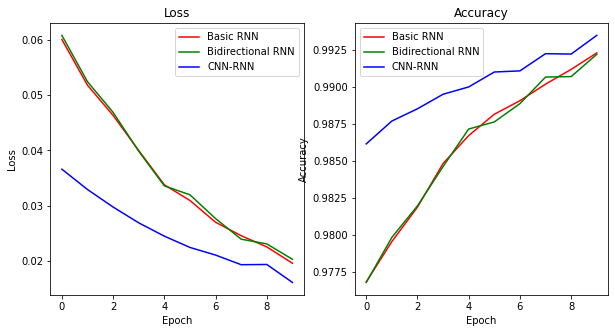

In [14]:
import matplotlib.pyplot as plt

# 모델 학습 과정 시각화
history_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))
history_2 = model_2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))
history_3 = model_3.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# 손실 및 정확도 그래프를 한 번에 출력
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 손실 그래프
ax1.plot(history_1.history['loss'], color='r', linestyle='-', label='Basic RNN')
ax1.plot(history_2.history['loss'], color='g', linestyle='-', label='Bidirectional RNN')
ax1.plot(history_3.history['loss'], color='b', linestyle='-', label='CNN-RNN')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# 정확도 그래프
ax2.plot(history_1.history['accuracy'], color='r', linestyle='-', label='Basic RNN')
ax2.plot(history_2.history['accuracy'], color='g', linestyle='-', label='Bidirectional RNN')
ax2.plot(history_3.history['accuracy'], color='b', linestyle='-', label='CNN-RNN')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()


In [15]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [19]:
import os
vocab_size = 10000
word_vector_dim = 16
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [21]:
from keras.layers import Embedding
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len))  # 128-dimensional embeddings


In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

ValueError: could not broadcast input array from shape (128,) into shape (16,)